## Stacking the Best Models
<pre><b>
This Kernel shows how the scores can be improved using Stacking Method.
Credit Goes to the following kernels
ref:
1. https://www.kaggle.com/zaharch/keras-model-boosted-with-plates-leak
2. https://www.kaggle.com/xhlulu/recursion-2-headed-efficientnet-2-stage-training
3. https://www.kaggle.com/antgoldbloom/doing-inference-using-google-automl
</b></pre>

## Stat Stack

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

cellstack
recursion-cellular-image-classification



In [2]:
from scipy.stats import rankdata
import glob
LABELS = ["sirna"]
all_files = glob.glob("../input/cellstack/*.csv")
all_files

['../input/cellstack/submission-174.csv',
 '../input/cellstack/submission-193.csv',
 '../input/cellstack/submission-201.csv',
 '../input/cellstack/submission-231.csv']

In [3]:
outs = [pd.read_csv(f, index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)

In [4]:
rank = np.tril(concat_sub.iloc[:,1:].corr().values,-1)
m = (rank>0).sum()
m_gmean, s = 0, 0
for n in range(min(rank.shape[0],m)):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/(m+n/10)
    print(w)
    m_gmean += w*(np.log(concat_sub.iloc[:,mx[0]+1])+np.log(concat_sub.iloc[:,mx[1]+1]))/2
    s += w
    rank[mx] = 1
m_gmean = np.exp(m_gmean/s).clip(0.0,1.0)

1.0
0.819672131147541
0.6451612903225806
0.4761904761904762


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
predict_list = []
predict_list.append(pd.read_csv("../input/cellstack/submission-174.csv")[LABELS].values)
predict_list.append(pd.read_csv("../input/cellstack/submission-201.csv")[LABELS].values)
predict_list.append(pd.read_csv("../input/cellstack/submission-231.csv")[LABELS].values)

In [6]:
import warnings
warnings.filterwarnings("ignore")
print("Rank averaging on ", len(predict_list), " files")
predictions = np.zeros_like(predict_list[0])
for predict in predict_list:
    for i in range(1):
        predictions[:, i] = np.add(predictions[:, i], rankdata(predict[:, i])/predictions.shape[0])  

predictions = predictions /len(predict_list)

submission = pd.read_csv('../input/recursion-cellular-image-classification/sample_submission.csv')
submission[LABELS] = predictions
submission.to_csv('AggStacker.csv', index=False)

Rank averaging on  3  files


In [7]:
sub_path = "../input/cellstack"
all_files = os.listdir(sub_path)
all_files

['submission-174.csv',
 'submission-193.csv',
 'submission-201.csv',
 'submission-231.csv']

In [8]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "var" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

In [9]:
# check correlation
concat_sub.iloc[:,1:ncol].corr()

,var0,var1,var2,var3
var0,1.000000,0.155259,0.191232,0.195601
var1,0.155259,1.000000,0.243492,0.237270
var2,0.191232,0.243492,1.000000,0.232355
var3,0.195601,0.237270,0.232355,1.000000


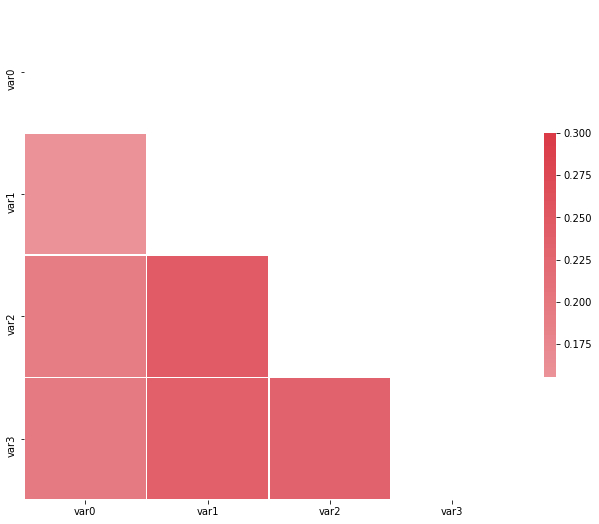

In [10]:
corr = concat_sub.iloc[:,1:7].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
# get the data fields ready for stacking
concat_sub['m_max'] = concat_sub.iloc[:, 1:ncol].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:ncol].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:ncol].median(axis=1)

In [12]:
concat_sub.describe()

,var0,var1,var2,var3,m_max,m_min,m_median
count,19897.000000,19897.000000,19897.000000,19897.000000,19897.000000,19897.000000,19897.000000
mean,676.155702,543.729457,560.524200,554.542896,864.565814,309.833342,580.276549
std,365.592197,313.796791,312.046642,320.031087,260.673533,248.020554,250.070307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,354.000000,291.000000,303.000000,278.000000,720.000000,114.000000,402.000000
50%,704.000000,536.000000,556.000000,544.000000,948.000000,255.000000,585.000000
75%,1064.000000,810.000000,822.000000,835.000000,1092.000000,444.000000,766.000000
max,1108.000000,1107.000000,1107.000000,1107.000000,1108.000000,1103.000000,1106.000000


In [13]:
cutoff_lo = 0.8
cutoff_hi = 0.2

# Mean Stacking

In [14]:
concat_sub['sirna'] = m_gmean.astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_mean.csv', 
                                        index=False, float_format='%.6f')

# Median Stacking

In [15]:
concat_sub['sirna']  = concat_sub['m_median'].astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_median.csv', 
                                        index=False, float_format='%.6f')

# Pushout + Median Stacking
>* Pushout strategy is bit aggresive

In [16]:
concat_sub['sirna']  = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             0, concat_sub['m_median']))
concat_sub[['id_code','sirna']].to_csv('stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

# MinMax + Mean Stacking
>* MinMax seems more gentle and it outperforms the previous one

In [17]:
concat_sub['m_mean'] = m_gmean.astype(int)
concat_sub['sirna']  = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_mean'])).astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

# MinMax + Median Stacking

In [18]:
concat_sub['sirna'] = np.where(np.all(concat_sub.iloc[:,1:ncol] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:ncol] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_median'])).astype(int)
concat_sub[['id_code','sirna']].to_csv('stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')